In [1]:
# Import libraries

import os
import math
import random
import numpy as np
import pandas as pd

import cv2
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D

##### The original dataset contains 82 characters belonging to both the Greek and Latin alphabets, as well as all sorts of mathematical functions and operators. A model that accepts all these characters as input will be much more complex, since there are difficulties in recognizing, for example, a and alpha, 1 and ! (factorial) and others. I built several different models that accept all characters from the dataset as input, but since this is still a learning task, I decided to make some simplification and use only 27 characters: all possible signs of mathematical operations -, +, etc., most often used letters of the Latin alphabet, triganometric functions, logarithm (I will make a reservation that I laid in logic that the logarithm has base 10), exponent and brackets.

In [2]:
# Display a list of folders in a directory with names corresponding to the characters they contain

path = 'data'

simbols = os.listdir(path)
print(simbols)

['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'div', 'e', 'log', 'mlp', 'sin', 'tan', 'x', 'y']


In [3]:
# Create a function that will open all the images in the corresponding directory in turn, convert to gray, 
# resize to the specified size (this is not relevant for the proposed dataset, just to make the solution more universal) 
# and put the numeric representation in the list

def load_simbol_images(folder, out_size=28, path=path):
    folder = os.path.join(path, folder)
    simbols=[]
    for filename in os.listdir(folder):
        image = cv2.imread(os.path.join(folder,filename))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        img_erode = cv2.erode(thresh, np.ones((2, 2), np.uint8), iterations=1)
        img_res = cv2.resize(img_erode, (out_size, out_size), interpolation=cv2.INTER_AREA)
        _, img_res = cv2.threshold(img_res, 210, 255, cv2.THRESH_BINARY)
        simbols.append(img_res)
    return simbols

In [4]:
# Using the created function, read the images in all 27 selected folders one by one, placing the processed images in x 
# and the directory name in y. This will create a dataset for training the model

x = np.empty((0, 28, 28), dtype=float)
y = np.empty(0, dtype='S3')
for simbol in simbols:
    sim_arr = load_simbol_images(simbol)
    x = np.append(x, sim_arr, axis=0)
    for i in range(0, len(sim_arr)):
        y = np.append(y, [simbol], axis=0)

In [5]:
# Add one more dimension to the x array, since the images are one-color, its size is 1
# Perform image color inversion and normalization

x = np.expand_dims(x, axis=3)
x = 255-x
x /= 255

In [6]:
# Convert the character values of y using LabelEncoder to numeric values, and then to binary class matrix

num_classes = len(simbols)

encoder = LabelEncoder()
y = encoder.fit_transform(y)

y = tf.keras.utils.to_categorical(y, num_classes)

In [52]:
# Divide the dataset into training and validation samples in the ratio of 0.9 to 0.1
# In order for the validation dataset to contain various variants of y, generate 
# a list of random numbers, which will be used as indexes

test_sample = random.sample(range(0, len(y)), int(len(y) * 0.1))
train_sample = list(set(range(len(y))) - set(test_sample))

train_x = x[train_sample, :, :]
train_y = y[train_sample]
test_x = x[test_sample, :, :]
test_y = y[test_sample]

print('train_x size:', train_x.shape)
print('train length:', train_x.shape[0])
print('test length:', test_x.shape[0])

train_x size: (79465, 28, 28, 1)
train length: 79465
test length: 8829


In [65]:
# Create and compiling a Sequential model with two 2D convolution layers, Flatten and Dense layer. 
# Take categorical_crossentropy as a loss function and accuracy as a metric.

input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
# Fit model on 15 epochs with a batch size of 250.

hist = model.fit(train_x, train_y, batch_size = 250, epochs=15, verbose=0, validation_data=(test_x, test_y))
#model.save('HESCNN.h5')

In [68]:
# Print model loss/metric

score = model.evaluate(test_x, test_y, verbose=0)
print('test loss:', round(score[0], 4))
print('test accuracy:', round(score[1], 4))

test loss: 0.1415
test accuracy: 0.9831


In [69]:
# Create a function that will take an image as input, calculate the outer common contour of all characters in the image
# and calculate the line of the middle of the image for further work with degrees

def ymean(img, frame=10):
    df = pd.DataFrame(columns=['x', 'y', 'w', 'h'])
    
    gray =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY)
    # Get contours
    contours,_ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for i in range(0, len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        df.loc[i] = [x,y,w,h]
    H = df.h.max()
    df = df[df.x != 0]
    df['hy'] = df.h + df.y
    minY = df.y.min() - frame if df.y.min() > frame else 0
    maxY = df.hy.max() + frame if H - df.y.max() > frame else H
    bsln = round((maxY - minY) / 2)
    return bsln

In [70]:
# Create a function that takes an image as input, determines the coordinates of the contours of each of the characters in 
# the image, changes the shape of the symbol canvas to square and changes the resize to 28x28, corresponding to the shape 
# of the model input. The position of the character is also determined to determine the degree or not and the order of the 
# characters. The function returns a list of tuples with the x-coordinate, the position of the character relative to the 
# baseline and the character itself.

def simbol_extract(img, ymean, out_size=28, frame=10):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=1)
    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    output = img.copy()

    simbols = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if hierarchy[0][idx][3] == 0 and w * h > 400:
            x, y, w, h = x - frame, y - frame, w + 2*frame, h + 2*frame # frame = 5 is indent  
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            simbol_crop = gray[y:y + h, x:x + w]
            # Resize letter canvas to square
            size_max = max(w, h)
            simbol_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                y_pos = size_max//2 - h//2
                simbol_square[y_pos:y_pos + h, 0:w] = simbol_crop
            elif w < h:
                x_pos = size_max//2 - w//2
                simbol_square[0:h, x_pos:x_pos + w] = simbol_crop
            else:
                simbol_square = simbol_crop
            # Fix the position of the symbol relative to the middle line of the general contour
            if y+h <= ymean:
                pos = 1
            elif y > ymean and (y + h) >= 1.8 * ymean:
                pos = 2
            elif y >= (0.4 * ymean) and (y + h) <= 1.6 * ymean:
                pos = 3
            else:
                pos = 0
            # Resize letter to 28x28 and add letter and its X-coordinate
            img_res = cv2.resize(simbol_square, (out_size, out_size), interpolation=cv2.INTER_AREA)
            _, img_res = cv2.threshold(img_res, 254, 255, cv2.THRESH_BINARY)
            img_erode = cv2.erode(img_res, np.ones((1, 1), np.uint8), iterations=1)
            simbols.append((x, pos, img_res))
    # Sort array inplace by X-coordinate
    simbols.sort(key=lambda x: x[0], reverse=False)
    # Show sequentially each separate simbol defined by the contour
    print(' ' * 15, 'Symbols defined by contours')
    n = len(simbols)
    fig, ax = plt.subplots(1, n, figsize=(5, 1))
    for i in range(0, n):
        ax[i].imshow(simbols[i][2], 'gray', origin='upper')
    plt.show()  
    return simbols

In [71]:
# Create a function that will in turn make a prediction for each of the characters in the image and recognize them, process the 
# sequence of characters recognized by the model, convert them into a mathematical function / equation and calculate the result

def handwritten_solver(smbls):
        
    s = ''
    # Labels indicating that a brackets is open
    flag = 0
    flag2 = 0
    # Loop through all the simbols in the image one by one
    k = len(smbls)
    for i in range(0, k):
        # Add two dimensions to the image array, perform image color inversion and normalization
        x = smbls[i][2].astype('float32')
        x = np.expand_dims(x, axis=2)
        x = np.expand_dims(x, axis=0)
        x = 255-x
        x /= 255
        # Identifying symbol with a Model
        prediction = model.predict(x, verbose = 0)
        prediction = [np.argmax(prediction)]
        prediction = encoder.inverse_transform(prediction)[0]
        # Perform simbol interpretation with reduction to a format acceptable for eval
        if prediction == 'mlp':
            prediction = '*'
        elif prediction == 'div':
            prediction = '/'
        elif prediction == ',' and simbols[i][1] == 2: # pos=2(below midline), defined in def simbol_extract
            prediction = '.'
        # the images of the characters 'div' and ','' are very similar, so if the condition above about the position 
        # of the character below the middle line is not met, we interpret it as '/'
        elif prediction == ',': 
            prediction = '/'
        # similarly, the images of the characters 'x' and 'mpl' are very similar, so if the condition of the position 
        # of the character in the range 0.2 - 0.8 of the general contour is met, interpret 'x' as '*'      
        elif prediction == 'x' and simbols[i][1] == 3:
            prediction = '*'
        # Add a call to the math library for e, sin, tan, log
        elif prediction == 'e':
            prediction = 'math.' + prediction
        elif prediction == 'sin' or prediction == 'tan':
            prediction = 'math.' + prediction + '('
            flag += 1
        elif prediction == 'log':
            prediction = 'math.' + prediction + '('
            flag2 += 1
        else:
            pass  
        # Add of the degree to the equation if the position of the symbol is above the midline
        if i > 0 and simbols[i-1][1] != 1 and simbols[i][1] == 1:
            s += '**' + prediction
        # Refine symbol below midline
        elif simbols[i][1] == 2:
            prediction = '.'
            s += prediction
        # Add a closing bracket if the label is not-null for log, tan and sin arguments
        elif flag != 0 and (prediction == '+' or prediction == '-' or prediction == '/' or prediction == '*'):
            s += ')' + prediction
            flag -= 1
        elif flag2 != 0 and (prediction == '+' or prediction == '-' or prediction == '/' or prediction == '*'):
            s += ', 10)' + prediction
            flag2 -= 1
        else:
            s += prediction
    # Add a closing bracket if the label is not-null
    if flag != 0:
        s += ')'
        flag -= 1
    elif flag2 !=0:
        s += ', 10)'
        flag2 -= 1
    return s, eval(s)

                               Origin equation


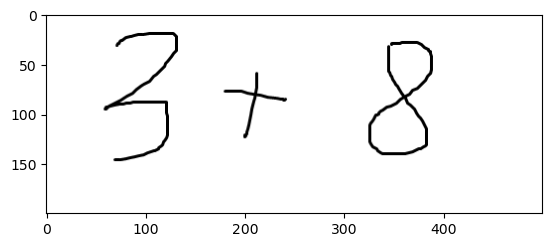

                Symbols defined by contours


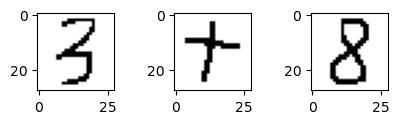

Results:

equation: 3+8
solution = 11
---------------------------------------------------------------------------
                               Origin equation


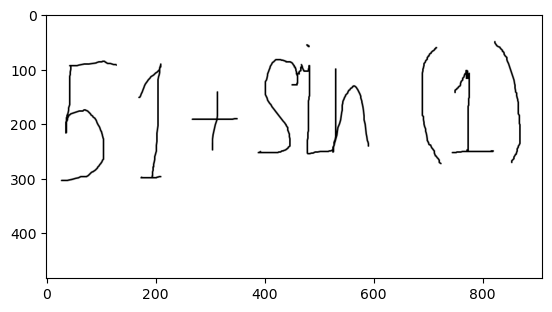

                Symbols defined by contours


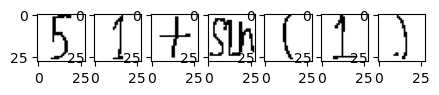

Results:

equation: 51+math.sin((1))
solution = 51.8414709848079
---------------------------------------------------------------------------
                               Origin equation


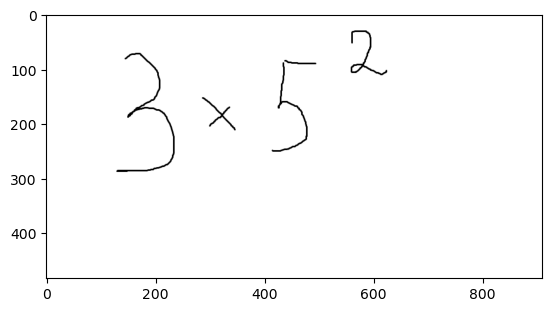

                Symbols defined by contours


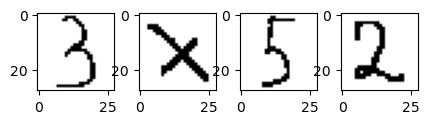

Results:

equation: 3*5**2
solution = 75
---------------------------------------------------------------------------
                               Origin equation


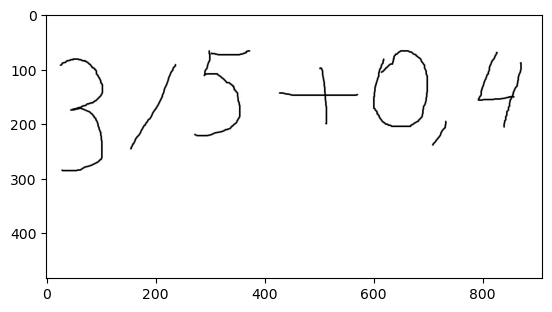

                Symbols defined by contours


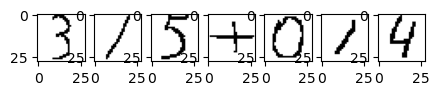

Results:

equation: 3/5+0.4
solution = 1.0
---------------------------------------------------------------------------
                               Origin equation


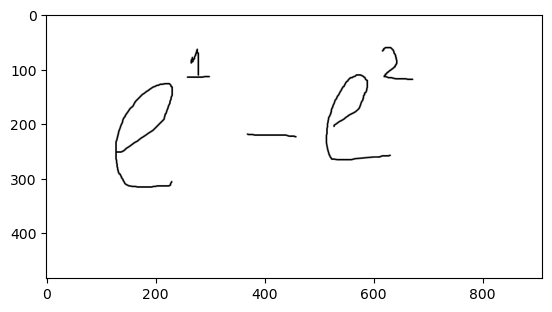

                Symbols defined by contours


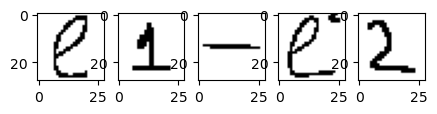

Results:

equation: math.e**1-math.e**2
solution = -4.670774270471604
---------------------------------------------------------------------------
                               Origin equation


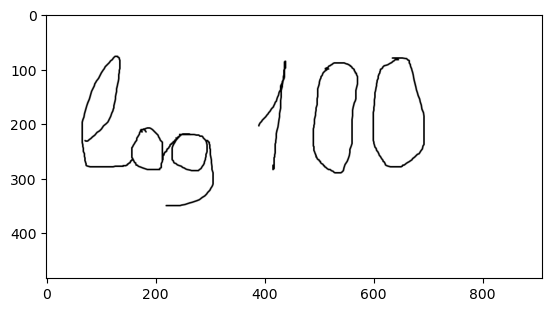

                Symbols defined by contours


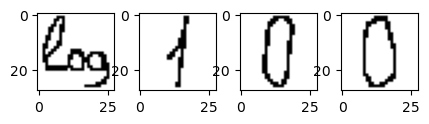

Results:

equation: math.log(100, 10)
solution = 2.0
---------------------------------------------------------------------------
                               Origin equation


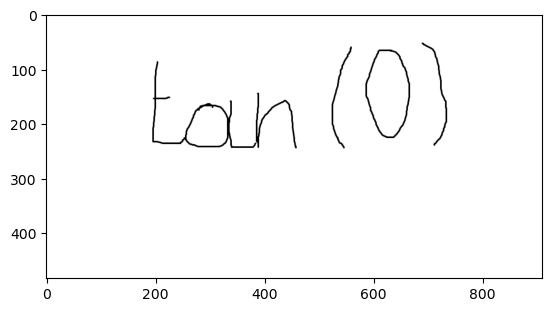

                Symbols defined by contours


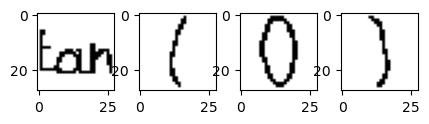

Results:

equation: math.tan((0))
solution = 0.0
---------------------------------------------------------------------------


In [72]:
# Check the result on formulas created in MS Paint

path = 'C:/Users/Konstantin/Documents/Стажировка Lets Grow More/Task 9/equation/'

for file in os.listdir(path):
    
    print(' ' * 30, 'Origin equation')
    image = cv2.imread('equation/' + file)
    plt.imshow(image, origin='upper')
    plt.show()
    
    baseline = ymean(image)
    simbols = simbol_extract(image, baseline)
        
    equation, res = handwritten_solver(simbols)
    print('Results:\n\nequation:', equation)  
    print('solution =', res)
    print('-' * 75)    